# VaRのモンテカルロシミュレーションをやってみる

- VaR (Value at Risk): 将来の一定期間内にある一定の確率のもとで被る損失額の最大値

In [1]:
%matplotlib inline

import arch
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
import statsmodels.tsa as tsa
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [2]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

prods = ['S&P500先物', '金先物']

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [3]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100


# 2019年の1年間のみのデータ

In [4]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

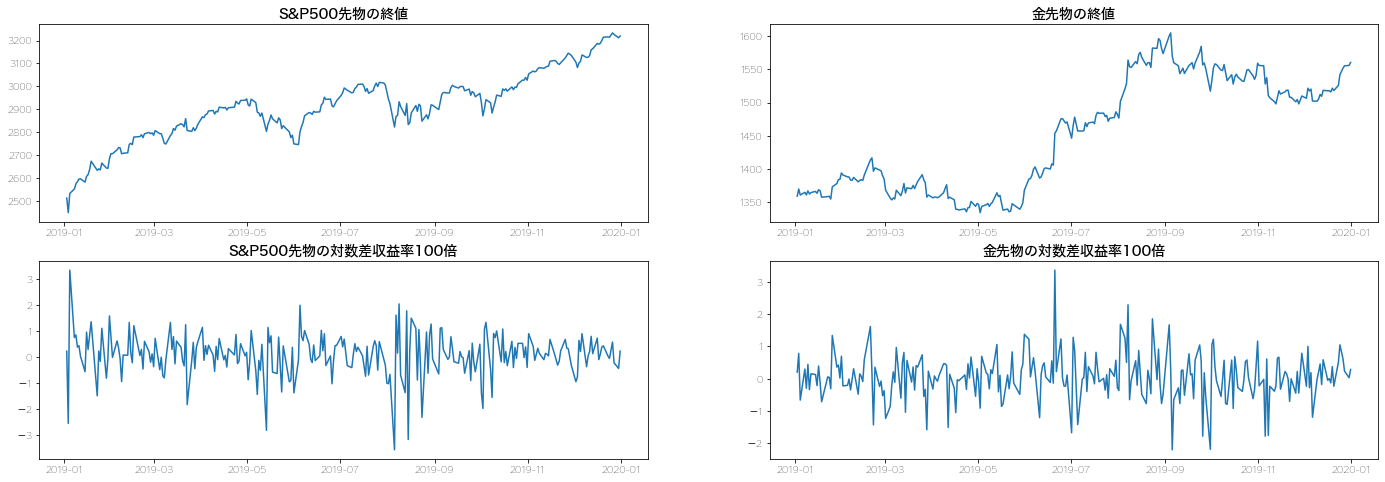

In [5]:
# 比較のため価格と対数差収益率を可視化しておく
fig, ax = plt.subplots(2, 2, figsize=(24,8))
for i, prod in enumerate(prods):
    ax[0,i].plot(rrdfs2019[i].index, rrdfs2019[i]['Close'])
    ax[0,i].set_title(f'{prod}の終値', fontsize=14, fontweight='semibold')
    ax[1,i].plot(rrdfs2019[i].index, rrdfs2019[i]['logCDiff'])
    ax[1,i].set_title(f'{prod}の対数差収益率100倍', fontsize=14, fontweight='semibold')

# EGARCHモデルのあてはめ

現状最もAICが小さいモデルはEGARCHのため、これを使う。

S%P500先物データにEGARCHを使う根拠
- 定常時系列とみなせる（ARXモデルを使うための条件）
    - Dicker-Fuller検定にかけた結果、単位根を持つという帰無仮説を棄却できたため
- 分散不均一性を持つ（ARCH/GARCH等を使うための条件）
    - ARモデルにあてはめたところ、誤差分散（残差の2乗）系列に時間依存構造があったため
- 価格の上昇・下落に対してボラティリティ変動が非対称だと想定される
    - 株式市場では一般に、価格が上昇した時より下落したときにボラティリティが上昇することが知られているため

In [6]:
egarch_models = [arch.arch_model(df['logCDiff'], vol='EGARCH', dist='gaussian', p=1, o=1, q=1) for df in rrdfs2019]
egaresults = [am.fit(disp='off') for am in egarch_models]
_ = [print(f'{prod}にEGARCH(1,1,1)モデルを当てはめたときのAIC：{res.aic}') for res, prod in zip(egaresults, prods)]

S&P500先物にEGARCH(1,1,1)モデルを当てはめたときのAIC：542.7985676455792
金先物にEGARCH(1,1,1)モデルを当てはめたときのAIC：505.5654876375514


# モンテカルロシミュレーション

モデルあてはめに使ったデータは2019年の1年間だから、2019年12月31日まで。だから、予測は2020年1月始めから1足、3足、5足、10足でそれぞれやってみる。それで実際の値動きが推定範囲におさまっているかを確認する。

In [7]:
# 対数差収益率から価格系列の復元
def restore_price_from_log_return(rs: np.ndarray, initial_price: float, magnif: int=100) -> np.ndarray:
    current = np.log(initial_price)
    prices = [initial_price]
    for r in rs:
        current = current + r / magnif
        prices.append(np.exp(current))

    return np.array(prices)

## 1足生成

1000回シミュレーションする

In [8]:
sim_model = arch.arch_model(None, p=1, o=1, q=1, vol='EGARCH', dist='gaussian')

sim_datas = [[], []]
for i, prod in enumerate(prods):
    for j in range(1000):
        sim_datas[i].append(sim_model.simulate(egaresults[i].params, nobs=1))

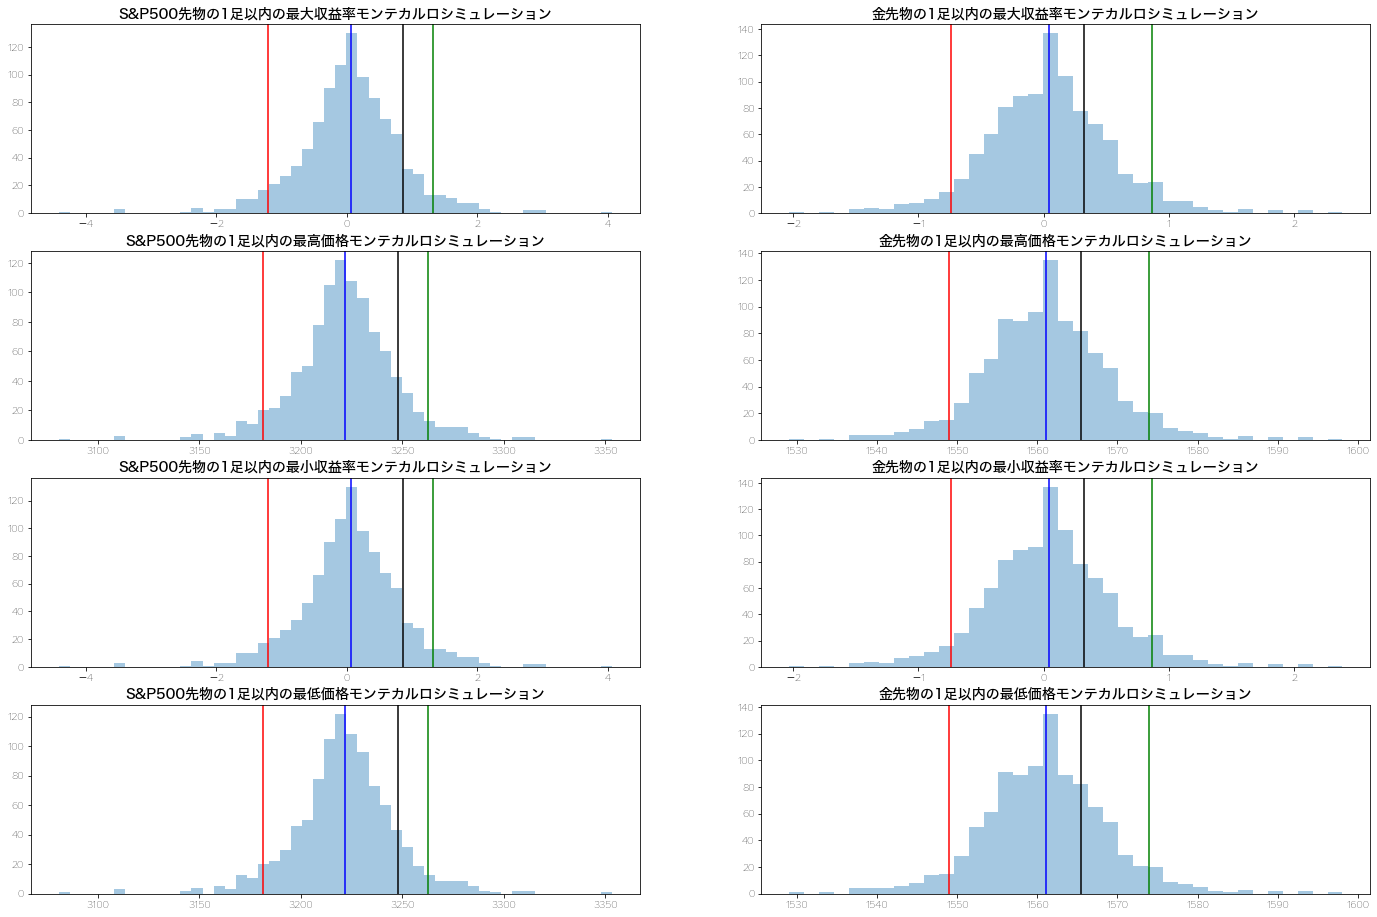

In [34]:
"""
S&P500先物と金先物それぞれでモンテカルロシミュレーションをした。
EGARCHモデルは2019年の1年間の対数差収益率へのあてはめでパラメータを決めたから、予測するのはその続きとして、2020年1月2日の収益率とした。
だから収益率から価格を復元する時は、2019年最後の日（モデルあてはめに使ったデータの最後のサンプル）の終値を初期値とした。
ここでやりたいのはVaRシミュレーション、つまり2019年最後の日にこの銘柄を買った場合に、次の足で一定確率のもとで被る最大損失額を推定すること。

それをもう少し一般化して、一定期間内（ここでは1足以内）における収益率の最大値と最小値の分布をそれぞれ作成し、5%ライン（赤）と50%ライン（青）と95%ライン（緑）を引いた。
5%ラインは、収益率（または価格）は95%の確率でこの値以上になるという推定で、
50%ラインは中央値、
95%ラインは、収益率（または価格）は95%の確率でこの値以下になるという推定。
したがって、95%^2 = 90.25%の確率で1足以内の収益率（または価格）はこの間におさまるという推定。

これは、予測精度が上がれば、そのまま仕掛けシグナルとして利用できる。
もし推定結果として、収益率が正になる確率が一定以上なら仕掛けるということができる。
また、この推定に基づいて、95%の確率で損失がこの範囲内におさまるというラインに損切り価格を置いておけば、損切りに引っかかる確率は5%以下ということになる。

予測することは2つあり、一定確率のもとで被る損失額の最大値、もう一つは一定確率のもとで得られる利益の最小額。
最大損失が十分小さく、かつ最小利益が十分大きいときに仕掛ければ最強だ。

全般的に知りたいことは、
- 保有期間中の値動き系列の期待値
損失について知りたいことは、
- 保有期間中の最大ドローダウン
利益について知りたいことは、
- 保有期間中にある価格に到達する確率
"""

max_pls = [np.array([d['data'].max() for d in sim_data]) for sim_data in sim_datas]
max_prices = [np.array([restore_price_from_log_return(d['data'], rrdfs2019[i]['Close'][-1])[1:].max() for d in sim_data]) for i, sim_data in enumerate(sim_datas)]

# 上のは最大値、こっちは最小値（ここでは1足だから結局一緒なんだけど）
min_pls = [np.array([d['data'].min() for d in sim_data]) for sim_data in sim_datas]
min_prices = [np.array([restore_price_from_log_return(d['data'], rrdfs2019[i]['Close'][-1])[1:].min() for d in sim_data]) for i, sim_data in enumerate(sim_datas)]

# 下側95%と上側95%
max_pl_conf_intervals = [np.quantile(max_pl, [0.05, 0.5, 0.95]) for max_pl in max_pls]
max_price_conf_intervals = [np.quantile(max_price, [0.05, 0.5, 0.95]) for max_price in max_prices ]
min_pl_conf_intervals = [np.quantile(min_pl, [0.05, 0.5, 0.95]) for min_pl in min_pls]
min_price_conf_intervals = [np.quantile(min_price, [0.05, 0.5, 0.95]) for min_price in min_prices ]

fig, ax = plt.subplots(4, 2, figsize=(24, 16))
for i, prod in enumerate(prods):
    # 最大収益率と最高価格
    sns.distplot(max_pls[i], kde=False, ax=ax[0, i])
    ax[0,i].axvline(max_pl_conf_intervals[i][0], c='red') # 5%
    ax[0,i].axvline(max_pl_conf_intervals[i][1], color='blue') # 50%
    ax[0,i].axvline(max_pl_conf_intervals[i][2], color='green') # 95%
    ax[0,i].axvline(rr_dfs[i].loc[dt.datetime(2020,1,2,17), 'logCDiff'], color='black') # 実際の値
    ax[0,i].set_title(f'{prod}の1足以内の最大収益率モンテカルロシミュレーション', fontsize=14, fontweight='semibold')
    sns.distplot(max_prices[i][1:], kde=False, ax=ax[1, i])
    ax[1,i].axvline(max_price_conf_intervals[i][0], color='red') # 5%
    ax[1,i].axvline(max_price_conf_intervals[i][1], color='blue') # 50%
    ax[1,i].axvline(max_price_conf_intervals[i][2], color='green') # 95%
    ax[1,i].axvline(rr_dfs[i].loc[dt.datetime(2020,1,2,17), 'Close'], color='black') # 実際の値
    ax[1,i].set_title(f'{prod}の1足以内の最高価格モンテカルロシミュレーション', fontsize=14, fontweight='semibold')

    # 最小収益率と最低価格
    sns.distplot(min_pls[i], kde=False, ax=ax[2, i])
    ax[2,i].axvline(min_pl_conf_intervals[i][0], c='red') # 5%
    ax[2,i].axvline(min_pl_conf_intervals[i][1], color='blue') # 50%
    ax[2,i].axvline(min_pl_conf_intervals[i][2], color='green') # 95%
    ax[2,i].axvline(rr_dfs[i].loc[dt.datetime(2020,1,2,17), 'logCDiff'], color='black') # 実際の値
    ax[2,i].set_title(f'{prod}の1足以内の最小収益率モンテカルロシミュレーション', fontsize=14, fontweight='semibold')
    sns.distplot(min_prices[i][1:], kde=False, ax=ax[3, i])
    ax[3,i].axvline(min_price_conf_intervals[i][0], color='red') # 5%
    ax[3,i].axvline(min_price_conf_intervals[i][1], color='blue') # 50%
    ax[3,i].axvline(min_price_conf_intervals[i][2], color='green') # 95%
    ax[3,i].axvline(rr_dfs[i].loc[dt.datetime(2020,1,2,17), 'Close'], color='black') # 実際の値
    ax[3,i].set_title(f'{prod}の1足以内の最低価格モンテカルロシミュレーション', fontsize=14, fontweight='semibold')

## 3足生成

1000回シミュレーションする

In [35]:
sim_model = arch.arch_model(None, p=1, o=1, q=1, vol='EGARCH', dist='gaussian')

sim_datas3 = [[], []]
for i, prod in enumerate(prods):
    for j in range(1000):
        sim_datas3[i].append(sim_model.simulate(egaresults[i].params, nobs=3))

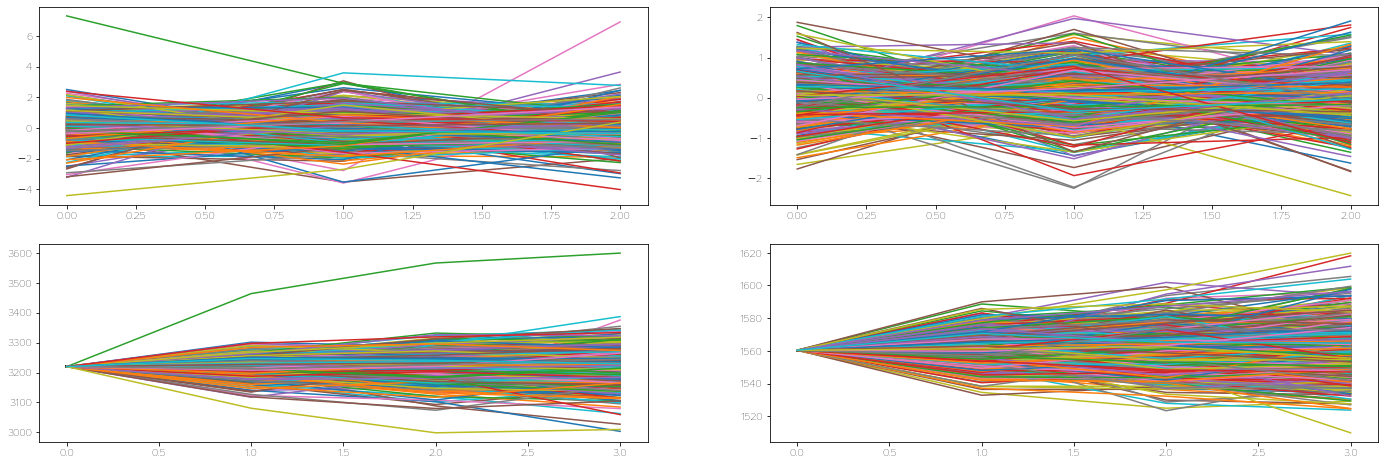

In [39]:
"""
ここで推定したいことは、
- 一定確率で損失がいくらにおさまるか。例えば、95%の確率で損失がいくら以内におさまるのか。
- 最大保有期間での損益の期待値
- 一定確率で価格がどこまで上昇するか。例えば、95%の確率で最大保有期間内に到達する価格はいくらか。
  つまり、その価格を手仕舞いの目標価格とすれば95%の確率でその価格で手仕舞えることになる。
"""

fig, ax = plt.subplots(2, 2, figsize=(24, 8))
for i, sim_data in enumerate(sim_datas3):
    for sim_d in sim_data:
        ax[0, i].plot(sim_d.index, sim_d['data'])
        ax[1, i].plot(np.arange(4), restore_price_from_log_return(sim_d['data'], rrdfs2019[i]['Close'][-1]))